<a href="https://colab.research.google.com/github/st3vejobs/Data-602-Assignment-07/blob/main/DATA_602_HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA 602 Assignment 07
## Shane Hylton




I will be using data from [Open Data](https://opendata.cityofnewyork.us/) from the City of New York. In particular, I will be exploring the wide world of squirrels. I am using the 2018 Central Park Squirrel Census for my analysis. I chose to explore this data because I love NYC's Open Data and they have data on some of the most interesting niche subjects, like squirrels. I am very drawn to nature. In the past, I have explored NYC's tree census, and I am excited to dive into the squirrel census.

Originally, I did not notice the X and Y columns (Latitude and Longitude), so I used regular expressions to parse the Latitude and Longitude data from the 'Lat/Long' column. I have left the procedure in this document and I will proceed as though the X and Y columns are not present. 

Removing all of the NA values in the remaining columns after tidying the dataset didn't remove more than 200 rows, and over 2800 rows remain.

In [ ]:
import pandas as pd
import numpy as np

raw = pd.DataFrame(pd.read_csv('https://raw.githubusercontent.com/st3vejobs/Data-602-Assignment-07/main/2018_Central_Park_Squirrel_Census_-_Squirrel_Data.csv'))

#print(raw['Date'])

def form_date(x):
  x['Date'] = pd.to_datetime(x['Date'], unit = 's')
  return x

raw['Date'] = pd.to_datetime(raw['Date'], format='%m%d%Y') # Code syntax assistance provided by Michael Ippolito
#raw['Date'] = pd.to_datetime(raw['Date'].dt.strftime('%Y-%m'))
#raw = form_date(raw)

#print(raw['Date'])
#print(raw.dtypes)
raw = raw.rename({'Unique Squirrel ID' : 'ID', 'Approaches' : 'Curious', 'Runs from' : 'Flees'}, axis = 1)
#print(raw.dtypes)
#print(raw.head())
del raw["Other Interactions"] #Included as another method for removing columns
raw = raw.drop(["Highlight Fur Color", "Color notes", "Above Ground Sighter Measurement", "Specific Location", "Other Activities"], axis = 1)

##print(raw.shape[0])
print(raw.head())

rawtrim = pd.DataFrame(raw.dropna())
raw = raw.fillna("")
#print(rawtrim.shape[0])

## String and Column Manipulation

Next, in order to appropriately map the squirrel population, I need to convert the "Lat/Long" column to a format that is possible for Python to process. 

In [35]:
#print(raw['Lat/Long'])

sq = pd.DataFrame(rawtrim)
print(type(sq))
print(sq['Lat/Long'])
#print(sq.iloc[:,30])
#print(sq.dtypes)

sq['Lon'] = sq['Lat/Long'].str.extract(r'(\-[0-9]+.[0-9]+)')
#print(sq['Lat'].str.isnumeric())
sq['Lon'] = pd.to_numeric(sq['Lon'])
#print(sq['Lat'])
sq['Lat'] = sq['Lat/Long'].str.extract(r'(\s[0-9]+.[0-9]+)')
sq['Lat'] = pd.to_numeric(sq['Lat'])
#print(sq['Lon'])

sq['Shift'] = (sq['Shift'].str.lower())
#print(sq['Shift'])

<class 'pandas.core.frame.DataFrame'>
0       POINT (-73.9702676472613 40.7762126854894)
1       POINT (-73.9541201789795 40.7931811701082)
2       POINT (-73.9582694312289 40.7917367820255)
3       POINT (-73.9674285955293 40.7829723919744)
4       POINT (-73.9722500196844 40.7742879599026)
                           ...                    
2819    POINT (-73.9645437409662 40.7811599933331)
2820    POINT (-73.9639431360458 40.7908677445466)
2821    POINT (-73.9704015859639 40.7825600069973)
2822    POINT (-73.9665871993517 40.7836775064883)
2823    POINT (-73.9754794191553 40.7696404489025)
Name: Lat/Long, Length: 2824, dtype: object


### Summary Statistics

With enough quantifiable data, I would use the .describe() function to display summary statistics on a number of important columns. Most of the data is boolean, so there is very little to glean from means and quartiles. 

In [28]:
summary = sq.agg(
    {
        "Running": ["sum"],
        "Chasing": ["sum"],
        "Climbing": ["sum"],
        "Eating": ["sum"],
        "Foraging": ["sum"],
        "Kuks": ["sum"], 
        "Quaas": ["sum"],
        "Moans": ["sum"],
        "Tail flags": ["sum"],
        "Tail twitches": ["sum"],
        "Curious": ["sum"],
        "Indifferent": ["sum"],
        "Flees": ["sum"]
    }
)
print(summary)
#print(type(summary))
summary_pct = summary/sq["Kuks"].count()
print(summary_pct)
#print(sq["Kuks"].value_counts())
#print(sq["Kuks"].sum())

     Running  Chasing  Climbing  Eating  Foraging  Kuks  Quaas  Moans  \
sum      700      257       625     716      1360    89     44      1   

     Tail flags  Tail twitches  Curious  Indifferent  Flees  
sum         148            414      170         1381    639  
      Running   Chasing  Climbing    Eating  Foraging      Kuks     Quaas  \
sum  0.247875  0.091006  0.221317  0.253541  0.481586  0.031516  0.015581   

        Moans  Tail flags  Tail twitches   Curious  Indifferent     Flees  
sum  0.000354    0.052408       0.146601  0.060198     0.489023  0.226275  


### Comfort Index

Because there are not many ways to quantify the data, I would like to construct a friendliness index to measure how friendly each squirrel is perceived to be. 

[This article](https://www.wildlifeonline.me.uk/animals/article/squirrel-behaviour-dominance-aggression-territoriality) contains some helpful information on how to classify different behaviors. While each behavior could be a sign of many different things, I will simplify the behaviors to friendly/docile = 1, and aggressive/apprehensive = -1. So, simply put: the higher the score, the more comfortable the squirrel appears. Chasing is described as an agonistic behavior. 

[This article](https://northamericannature.com/what-sounds-do-squirrels-make/) offers good perspective into what each call means. For simplicity, I will assign Kuks and Quaas to the apprehensive category, signifying the presence of predators. Moans will be assigned to the docile and friendly category, assuming that the moans are defining female squirrels signifying a readiness to mate. 
Climbing, eating, foraging, curiosity, and indifference all signify some level of normal behavior from the squirrel being observed. These behaviors don't imply aggression towards the observer or other squirrels. 






In [29]:
comfort = {
    "Running": -1,
    "Chasing": -1,
    "Climbing": 1,
    "Eating": 1,
    "Foraging": 1,
    "Kuks": -1,
    "Quaas": -1,
    "Moans": 1,
    "Tail flags": -1,
    "Tail twitches": -1,
    "Curious": 1,
    "Indifferent": 1,
    "Flees": -1
}

Each comfort index value will be appended to the existing dataframe, and a total comfort score will be calculated. I will attempt to apply the dictionary to the dataframe. For the record, I will leave the attempt at using the dictionary in a comment. I need to use loops in order to finish the scoring process (I was looking to avoid this by using the dictionary).

In [30]:
#sq["runscore"] = sq["Running"].apply(lambda x: comfort.get(x))
#print(sq["runscore"])
print(len(sq))

2824


## Comfort Score Calculation

In this section, I add new columns and add a column with calculations based on existing columns. I also group the data by two columns and sort it. 

In [37]:
sq.reset_index(drop = True, inplace = True)
sq["runscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Running"] == True:
    sq.at[i, "runscore"] += -1
  else:
    sq.at[i, "runscore"] += 1

sq["chasescore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Chasing"] == True:
    sq.at[i, "chasescore"] += -1
  else:
    sq.at[i, "chasescore"] += 1

sq["climbscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Climbing"] == True:
    sq.at[i, "climbscore"] += 1
  else:
    sq.at[i, "climbscore"] += -1

sq["eatscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Eating"] == True:
    sq.at[i, "eatscore"] += 1
  else:
    sq.at[i, "eatscore"] += -1

sq["foragescore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Foraging"] == True:
    sq.at[i, "foragescore"] += 1
  else:
    sq.at[i, "foragescore"] += -1

sq["kukscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Kuks"] == True:
    sq.at[i, "kukscore"] += -1
  else:
    sq.at[i, "kukscore"] += 1

sq["quaascore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Quaas"] == True:
    sq.at[i, "quaascore"] += -1
  else:
    sq.at[i, "quaascore"] += 1

sq["moanscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Moans"] == True:
    sq.at[i, "moanscore"] += 1
  else:
    sq.at[i, "moanscore"] += -1

sq["flagscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Tail flags"] == True:
    sq.at[i, "flagscore"] += -1
  else:
    sq.at[i, "flagscore"] += 1

sq["twitchscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Tail twitches"] == True:
    sq.at[i, "twitchscore"] += -1
  else:
    sq.at[i, "twitchscore"] += 1

sq["curiousscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Curious"] == True:
    sq.at[i, "curiousscore"] += 1
  else:
    sq.at[i, "curiousscore"] += -1

sq["indifferentscore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Indifferent"] == True:
    sq.at[i, "indifferentscore"] += 1
  else:
    sq.at[i, "indifferentscore"] += -1

sq["fleescore"] = 0
for i in range(0,len(sq)):
  if sq.at[i, "Flees"] == True:
    sq.at[i, "fleescore"] += -1
  else:
    sq.at[i, "fleescore"] += 1

for i in range(0,len(sq)):
  sq.at[i, "comfortscore"] = sq.at[i, "runscore"] + sq.at[i, "chasescore"] + sq.at[i, "climbscore"] + sq.at[i, "eatscore"] + sq.at[i, "foragescore"] + sq.at[i, "kukscore"] + sq.at[i, "quaascore"] + sq.at[i, "moanscore"] + sq.at[i, "flagscore"] + sq.at[i, "twitchscore"] + sq.at[i, "curiousscore"] + sq.at[i, "indifferentscore"] + sq.at[i, "fleescore"]


#print(sq["comfortscore"])

sq.sort_values(by = ['Primary Fur Color', 'comfortscore'], inplace = True, ascending = False)
print(sq.head())


              X          Y              ID Hectare Shift       Date  \
2038 -73.969913  40.774447  12F-PM-1007-14     12F    pm 2018-10-07   
732  -73.980854  40.767870   1B-AM-1012-17     01B    am 2018-10-12   
774  -73.964515  40.777257  17I-AM-1014-04     17I    am 2018-10-14   
1010 -73.958411  40.790278  32F-PM-1008-02     32F    pm 2018-10-08   
1075 -73.969407  40.780566  18C-PM-1018-06     18C    pm 2018-10-18   

      Hectare Squirrel Number       Age Primary Fur Color  \
2038                       14     Adult              Gray   
732                        17     Adult              Gray   
774                         4     Adult              Gray   
1010                        2     Adult              Gray   
1075                        6  Juvenile              Gray   

     Combination of Primary and Highlight Color  ... foragescore  kukscore  \
2038                       Gray+Cinnamon, White  ...           1         1   
732                        Gray+Cinnamon, White  .

### Summary Statistics, grouping, and filtering




In [36]:
print('Mean: ')
print(sq[["Lat", "Lon", "comfortscore"]].mean())
print()
print('Median: ')
print(sq[["Lat", "Lon", "comfortscore"]].median())

print(sq[['Lat', 'Lon', 'comfortscore']].describe())

sq_filter = sq[sq["Primary Fur Color"] == "Gray"]
print(sq_filter.head())

print()
print("Mean Comfort Score by Fur Color")
print(sq[["Primary Fur Color", "comfortscore"]].groupby("Primary Fur Color").mean())

print()
print("Median Comfort Score by Fur Color")
print(sq[["Primary Fur Color", "comfortscore"]].groupby("Primary Fur Color").median())

print()
print("Maximum Comfort Score by Fur Color")
print(sq[["Primary Fur Color", "comfortscore"]].groupby("Primary Fur Color").max())

print()
print("Minimum Comfort Score by Fur Color")
print(sq[["Primary Fur Color", "comfortscore"]].groupby("Primary Fur Color").min())


Mean: 
Lat             40.780687
Lon            -73.967282
comfortscore     2.389518
dtype: float64

Median: 
Lat             40.777969
Lon            -73.968717
comfortscore     3.000000
dtype: float64
               Lat          Lon  comfortscore
count  2824.000000  2824.000000   2824.000000
mean     40.780687   -73.967282      2.389518
std       0.010277     0.007718      2.918878
min      40.764911   -73.981159     -7.000000
25%      40.771505   -73.973199      1.000000
50%      40.777969   -73.968717      3.000000
75%      40.791155   -73.960321      5.000000
max      40.800119   -73.949842     11.000000
           X          Y              ID Hectare Shift       Date  \
0 -73.970268  40.776213  13E-AM-1017-05     13E    am 2018-10-17   
1 -73.954120  40.793181  36H-AM-1010-02     36H    am 2018-10-10   
2 -73.958269  40.791737  33F-AM-1008-02     33F    am 2018-10-08   
3 -73.967429  40.782972  21C-PM-1006-01     21C    pm 2018-10-06   
4 -73.972250  40.774288  11D-AM-1010-03    

## Conclusion

As a later exercise, I would like to try to plot comfort score overlayed on map of Central Park (lat/lon). From the data, I found that Cinnamon colored squirrels seem to be the most comfortable squirrels in Central Park, with the black squirrels being the most uncomfortable. Interestingly, the median score for each category turned out to be 3.0. I would like to dive deeper into this set and see if squirrels are more comfortable in the morning, afternoon, or at night. I would also like to determine which areas of the park squirrels seem to be the most comfortable. 

In [38]:
print()
print("Mean Comfort Score by Shift")
print(sq[["Shift", "comfortscore"]].groupby("Shift").mean())


print()
print("Summary Information for Comfort Score grouped by Shift")
print(sq[["Shift", "comfortscore"]].groupby("Shift").describe())


Mean Comfort Score by Shift
       comfortscore
Shift              
am         2.465409
pm         2.327320

Summary Information for Comfort Score grouped by Shift
      comfortscore                                              
             count      mean       std  min  25%  50%  75%   max
Shift                                                           
am          1272.0  2.465409  2.884135 -7.0  1.0  3.0  5.0   9.0
pm          1552.0  2.327320  2.946517 -7.0  1.0  3.0  5.0  11.0


### Plotting Attempt

Interestingly, when x = Longitude and y = Latitude, a mirror image of Central Park is created. x = Latitude and y = Longitude provides a surprisingly accurate representation of the land in Central Park as the blue and its bodies of water and buildings as the white sections. The Jacqueline Kennedy Onassis Reservoir is clearly visible in both plots. In the first, it is mirrored, but in the second, it is easily discernible as the Reservoir.


After some confusion, I realized that the latitude and longitude measurements are in the wrong order. It is not my fault either, the coordinates are flipped in the NYC Squirrel Census data. I will fix that but I will leave the commentary. I will also try to get in touch with the Open Data team and see if they will change that for future users. 

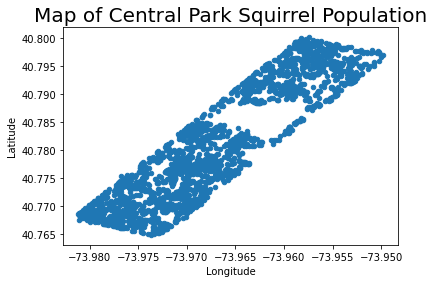

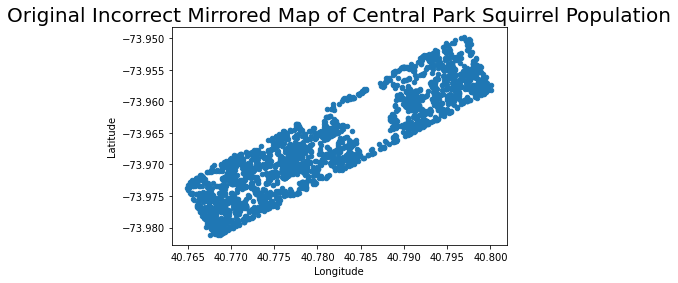

In [40]:
import matplotlib.pyplot as plt
sq.plot.scatter('Lon', 'Lat')
plt.title('Map of Central Park Squirrel Population', fontsize = 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print()
import matplotlib.pyplot as plt
sq.plot.scatter(x = 'Lat',y = 'Lon')
plt.title('Original Incorrect Mirrored Map of Central Park Squirrel Population', fontsize = 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()